## Day 34 Lecture 2 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset describing TripAdvisor reviews for Las Vegas hotels loaded below and analyze the model generated for this dataset.

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
vegas = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/LasVegasTripAdvisorReviews-Dataset.csv', sep=';')

In [0]:
vegas.head()

Check for missing data and remove all rows with missing data

In [0]:
# answer below: 
vegas.info()


In [0]:
for col in vegas.columns:
    print(vegas[col].value_counts())

vegas.columns = [x.lower().replace('.', '').replace(' ', '_') for x in vegas.columns]

How many reviews do we have for each hotel in the dataset?

In [0]:
vegas.info()

In [0]:
# answer below:
df = vegas['hotel_name']
df = pd.concat([df, vegas['nr_hotel_reviews']], axis = 1)
df.groupby(by = ['hotel_name']).sum()

We would like to predict the score variable. Examine the dataset and decide which columns should be turned into dummy variables and transform the data. Also, where we have two columns with redundant information, remove one of the two columns. Remove the hotel stars column.

In [0]:
# answer below:
vegas.columns


In [0]:
plt.hist(vegas['score'])

In [0]:
df_v = vegas.drop(columns = ['user_continent','user_country', 'review_month', 'review_weekday', 'hotel_stars'])

In [0]:
dummies = pd.get_dummies(vegas['traveler_type'], drop_first = True, prefix = 'traveler_type')
df_v = pd.concat((df_v, dummies), axis = 1)

binary = ['free_internet','pool', 'gym', 'tennis_court', 'spa', 'casino']
for col in binary:
    df_v = pd.concat((df_v, pd.get_dummies((vegas[col]), drop_first= True, prefix = col)), axis = 1)
df_v = pd.concat((df_v, pd.get_dummies(vegas['period_of_stay'], drop_first = True, prefix = 'period_of_stay')), axis = 1)
df_v = pd.concat((df_v, pd.get_dummies(vegas['hotel_name'], drop_first = True, prefix = 'hotel_name')), axis = 1)
# df_v = pd.concat([df_v, pd.get_dummies(vegas['user_country'], prefix= 'user_country')], axis = 1)
df_v.drop(columns = binary, inplace= True)
df_v.drop(columns = ['traveler_type','period_of_stay', 'hotel_name' ], inplace = True, axis = 1)


In [0]:
df = vegas.drop(columns=vegas.select_dtypes(exclude='number'), axis=1)

for column in vegas.select_dtypes(exclude='number').columns: 
    df = pd.concat([df,pd.get_dummies(vegas[column], drop_first=True)], axis=1)
df.head()

In [0]:
# answer below:

df_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 39 columns):
nr_reviews                                                        504 non-null int64
nr_hotel_reviews                                                  504 non-null int64
helpful_votes                                                     504 non-null int64
score                                                             504 non-null int64
nr_rooms                                                          504 non-null int64
member_years                                                      504 non-null int64
traveler_type_Couples                                             504 non-null uint8
traveler_type_Families                                            504 non-null uint8
traveler_type_Friends                                             504 non-null uint8
traveler_type_Solo                                                504 non-null uint8
free_internet_YES                            

Split the data into train and test (20% in test)

In [0]:
from sklearn.model_selection import train_test_split

X = df_v.drop('score', axis = 1)
y = df_v['score']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 34)

Create a graident boosted regression model for predicting the score. To produce the accuracy score for the test data, first round the prediction and then compare to the observed.

In [0]:
# answer below:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

gbr.score(X_train, y_train), gbr.score(X_test, y_test)


(0.6301743162268735, -0.15211783764545106)

In [0]:
gbr.predict(X_test)

In [0]:
y.hist()

In [0]:
y_train.hist()

In [0]:
y_test.hist()

Try again with a learning rate of 0.8 and 0.3 and compare the results.

In [0]:
# answer below:
gbr = GradientBoostingRegressor(learning_rate = 0.1, max_depth= 7, n_estimators = 100)
gbr.fit(X_train, y_train)



GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:

from sklearn.metrics import accuracy_score
predict_train = gbr.predict(X_train)
predict_test = gbr.predict(X_test)

predict_train.astype(int)
predict_test.astype(int)
accuracy_score(y_test,(predict_test.round()).astype(int))

0.39603960396039606

Weak learner 0 R^2: -146.2621723927862
Weak learner 20 R^2: -146.01578575379662
Weak learner 40 R^2: -145.83544006991696
Weak learner 60 R^2: -145.69778317192697
Weak learner 80 R^2: -145.58928898894746
Weak learner 100 R^2: -145.50159087096063


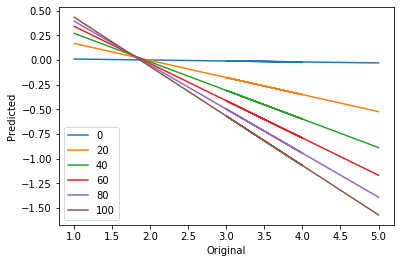

Overall R^2:
-0.9999024910630409


In [0]:
from sklearn import tree

preds = pd.DataFrame()
labels = []

uniquex = df_v['score'].unique()

# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs.
for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X_train,y_train)
    
    # Get and store predicted values.
    pred = decision_tree.predict(X_test)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    y_test = y_test - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, decision_tree.score(X_test, y_test)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(y_test, bestpred, 1))(uniquex))
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(y_test, predicted)[0, 1])

In [0]:
X.info()

In [0]:
predict_train.round()

array([4., 3., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 5., 5., 4.,
       4., 4., 5., 4., 4., 4., 5., 5., 4., 4., 4., 4., 5., 4., 2., 4., 5.,
       4., 4., 4., 4., 5., 3., 4., 4., 4., 4., 3., 4., 5., 5., 5., 5., 4.,
       4., 5., 3., 4., 4., 4., 4., 4., 2., 4., 4., 5., 4., 5., 5., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 5., 4., 1., 4., 5., 3., 4., 4., 5., 4.,
       4., 4., 3., 5., 3., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 5., 5., 4., 1., 4., 4., 4., 5., 3., 5., 5., 4., 5., 4., 4., 4.,
       3., 4., 3., 4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4., 4.,
       4., 5., 4., 4., 4., 4., 5., 3., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       2., 4., 4., 4., 4., 5., 5., 4., 5., 5., 4., 3., 4., 4., 4., 3., 5.,
       3., 4., 4., 4., 4., 3., 5., 5., 5., 4., 4., 4., 5., 4., 4., 5., 4.,
       4., 4., 3., 5., 4., 3., 5., 4., 4., 5., 4., 5., 4., 4., 5., 3., 5.,
       4., 4., 4., 3., 5., 4., 4., 4., 4., 3., 4., 5., 5., 4., 4., 4., 4.,
       5., 4., 1., 4., 4.

In [0]:
feature_importance = gbr.feature_importances_

plt.figure(figsize= (30,30))
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()